In [1]:
import pandas as pd
import numpy as np


In [2]:
# Cargar datasets
df_orders = pd.read_excel('./datasets/df_orders.xlsx')
df_vehicle = pd.read_excel('./datasets/df_vehicle.xlsx')
df_distance_km = pd.read_excel('./datasets/df_distance_km.xlsx')

In [3]:
# Preprocesar datos
df_orders[["mes", "año"]] = df_orders["mes_anio"].str.split("-", expand=True).astype(int)
df_orders.drop(columns=["mes_anio"], inplace=True)
df_orders["cliente"] = df_orders["cliente"].apply(lambda x: f'cliente_{x}')

In [4]:
import pulp

# La matriz de distancia tiene columnas de clientes y almacén pero no filas, le ponemos las columnas en las filas para tener ok la matriz de distancia
clientes_y_almacen = [f"cliente_{i+1}" for i in range(len(df_orders))] + ["Almacén"]  # Lista de clientes + almacén
df_distance_km.index = clientes_y_almacen
df_distance_km.columns = clientes_y_almacen

df_orders["cliente"] = [f"cliente_{i+1}" for i in range(len(df_orders))]  # Lista de clientes

# Convertir la matriz de distancias a un diccionario
dicc_distancia = df_distance_km.to_dict()

# Crear el problema de optimización
prob = pulp.LpProblem("Optimización_Rutas_P1", pulp.LpMinimize)

# Parámetros
clientes = [f"cliente_{i+1}" for i in range(len(df_orders))]
vehiculos = list(df_vehicle["vehiculo_id"])
demanda = dict(zip(df_orders["cliente"], df_orders["order_demand"]))
capacidad_vehiculo = dict(zip(df_vehicle["vehiculo_id"], df_vehicle["capacidad_kg"]))
coste_km = dict(zip(df_vehicle["vehiculo_id"], df_vehicle["costo_km"]))
autonomia = dict(zip(df_vehicle["vehiculo_id"], df_vehicle["autonomia_km"]))
nombre_almacen = "Almacén"

# Variables de decisión: 1 si el vehículo v atiende al cliente i, 0 si no
x = pulp.LpVariable.dicts("x", [(i, v) for i in clientes for v in vehiculos], cat="Binary")

# Restricción 1: Cada cliente debe ser atendido por exactamente un vehículo
for i in clientes:
    prob += pulp.lpSum(x[(i, v)] for v in vehiculos) == 1, f"Asignación_cliente_{i}"

# Restricción 2: La suma de demandas de los clientes asignados a un vehículo no puede exceder su capacidad
for v in vehiculos:
    prob += pulp.lpSum(demanda[i] * x[(i, v)] for i in clientes) <= capacidad_vehiculo[v], f"Capacidad_vehiculo_{v}"

# Restricción 3: La autonomía del vehículo no puede ser excedida
for v in vehiculos:
    prob += pulp.lpSum(
        (dicc_distancia[nombre_almacen][i] + dicc_distancia[i][nombre_almacen]) * x[(i, v)]
        for i in clientes
    ) <= autonomia[v], f"Autonomía_vehiculo_{v}"

# Restricción 4: Evitar rutas con distancia 0
for i in clientes:
    for v in vehiculos:
        if dicc_distancia[nombre_almacen][i] == 0 or dicc_distancia[i][nombre_almacen] == 0:
            prob += x[(i, v)] == 0, f"Ruta_no_valida_almacen_cliente_{i}_vehiculo_{v}"
        for j in clientes:
            if i != j and dicc_distancia[i][j] == 0:
                prob += x[(i, v)] + x[(j, v)] <= 1, f"Ruta_no_valida_{i}_a_{j}_vehiculo_{v}"

# Función objetivo: Minimizar el coste total
prob += pulp.lpSum(
    x[(i, v)] * (dicc_distancia[nombre_almacen][i] + dicc_distancia[i][nombre_almacen]) * coste_km[v]
    for i in clientes for v in vehiculos
), "Minimizar_coste"

# Resolver el problema
prob.solve()

# Mostrar resultados
print(f"Estado del problema: {pulp.LpStatus[prob.status]}")

if pulp.LpStatus[prob.status] == "Optimal":
    solucion = {
        (i, v): pulp.value(x[(i, v)]) for i in clientes for v in vehiculos if pulp.value(x[(i, v)]) > 0
    }
    rutas_por_vehiculo = {v: {"ruta": [], "carga": 0, "distancia": 0, "coste": 0} for v in vehiculos}
    
    # Procesar la solución para calcular detalles por vehículo
    for (i, v), valor in solucion.items():
        if valor > 0:
            rutas_por_vehiculo[v]["ruta"].append(i)
            rutas_por_vehiculo[v]["carga"] += demanda[i]

    # Calcular distancia secuencial para cada vehículo
    for v, datos in rutas_por_vehiculo.items():
        if datos["ruta"]:
            ruta = [nombre_almacen] + datos["ruta"] + [nombre_almacen]  # Añadir almacén al inicio y al final
            distancia_total = 0
            for j in range(len(ruta) - 1):
                distancia_total += dicc_distancia[ruta[j]][ruta[j + 1]]
            datos["distancia"] = distancia_total
            datos["coste"] = distancia_total * coste_km[v]

    # Mostrar detalles por vehículo
    print("\nDetalles por vehículo:")
    for v, datos in rutas_por_vehiculo.items():
        if datos["ruta"]:
            print(f"Vehículo {v}:")
            print(f"  - Ruta: Almacén -> {' -> '.join(datos['ruta'])} -> Almacén")
            print(f"  - Carga total de la ruta: {datos['carga']} kg")
            print(f"  - Distancia total de la ruta: {datos['distancia']:.2f} km")
            print(f"  - Coste total de la ruta: {datos['coste']:.2f} €")
            print("-" * 60)
    
    # Mostrar el coste total
    coste_total = pulp.value(prob.objective)
    print(f"\nCoste total de toda la entrega de suministro: {coste_total:.2f} €")
else:
    print("No se encontró una solución óptima para las peticiones.")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/pedrohd/Library/Python/3.9/lib/python/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/6s/rbb4xdjd1d15rp4z5_w0yt8c0000gn/T/d5620cfd64fa4f0e87f95d4c9136a16c-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/6s/rbb4xdjd1d15rp4z5_w0yt8c0000gn/T/d5620cfd64fa4f0e87f95d4c9136a16c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 205 COLUMNS
At line 1262 RHS
At line 1463 BOUNDS
At line 1584 ENDATA
Problem MODEL has 200 rows, 120 columns and 696 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 57.5584 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 19 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 19 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 19 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 

In [5]:
df_distance_km

,cliente_1,cliente_2,cliente_3,cliente_4,cliente_5,cliente_6,cliente_7,cliente_8,cliente_9,cliente_10,...,cliente_12,cliente_13,cliente_14,cliente_15,cliente_16,cliente_17,cliente_18,cliente_19,cliente_20,Almacén
cliente_1,0.0000,7.5625,15.5365,1.1998,4.7145,1.7407,7.9408,17.1947,4.2933,3.2659,...,6.0225,5.4470,2.2133,11.1505,1.5775,10.8288,9.1456,20.4871,22.1445,3.6114
cliente_2,7.5625,0.0000,3.3838,7.7433,14.5720,8.5237,0.4847,13.7974,10.1522,7.1521,...,10.1049,2.6961,13.4907,18.0835,7.0275,19.8218,8.2737,9.6369,19.1038,10.7361
cliente_3,15.5365,3.3838,0.0000,12.5438,0.0000,0.0000,0.0000,16.0355,13.9120,13.0649,...,12.3430,5.0114,15.7289,17.9217,9.6824,22.0599,10.5118,7.7574,16.5997,13.9021
cliente_4,1.1998,7.7433,12.5438,0.0000,5.0721,0.9119,7.5798,17.4095,3.5781,3.3451,...,6.2330,4.7117,2.8799,11.3610,1.3127,11.1926,9.3561,20.7019,21.1518,3.3673
cliente_5,4.7145,14.5720,0.0000,5.0721,0.0000,4.8187,0.0000,0.0000,0.0000,7.2170,...,6.8738,9.1064,3.6476,12.0019,5.4347,5.2872,9.9969,21.3384,25.5947,4.5417
cliente_6,1.7407,8.5237,0.0000,0.9119,4.8187,0.0000,7.8866,20.0472,2.9060,4.0899,...,8.8750,5.0185,3.2185,14.0030,2.0575,11.4008,11.9981,19.7467,20.4797,2.6952
cliente_7,7.9408,0.4847,0.0000,7.5798,0.0000,7.8866,0.0000,13.9893,10.1499,7.3440,...,10.2968,0.0000,0.0000,0.0000,7.2194,20.0138,8.4656,9.8289,17.1722,10.9280
cliente_8,17.1947,13.7974,16.0355,17.4095,0.0000,20.0472,13.9893,0.0000,19.6963,12.9161,...,12.3127,13.5906,14.8623,5.9742,14.6038,22.6587,8.9984,15.5515,34.1368,20.8703
cliente_9,4.2933,10.1522,13.9120,3.5781,0.0000,2.9060,10.1499,19.6963,0.0000,6.8679,...,10.1024,7.7229,4.5536,15.2304,4.8355,9.7565,13.2255,24.5670,22.9781,1.0494
cliente_10,3.2659,7.1521,13.0649,3.3451,7.2170,4.0899,7.3440,12.9161,6.8679,0.0000,...,2.3061,4.9896,0.0000,8.2196,0.0000,10.8948,5.3050,17.5604,21.1407,5.9516


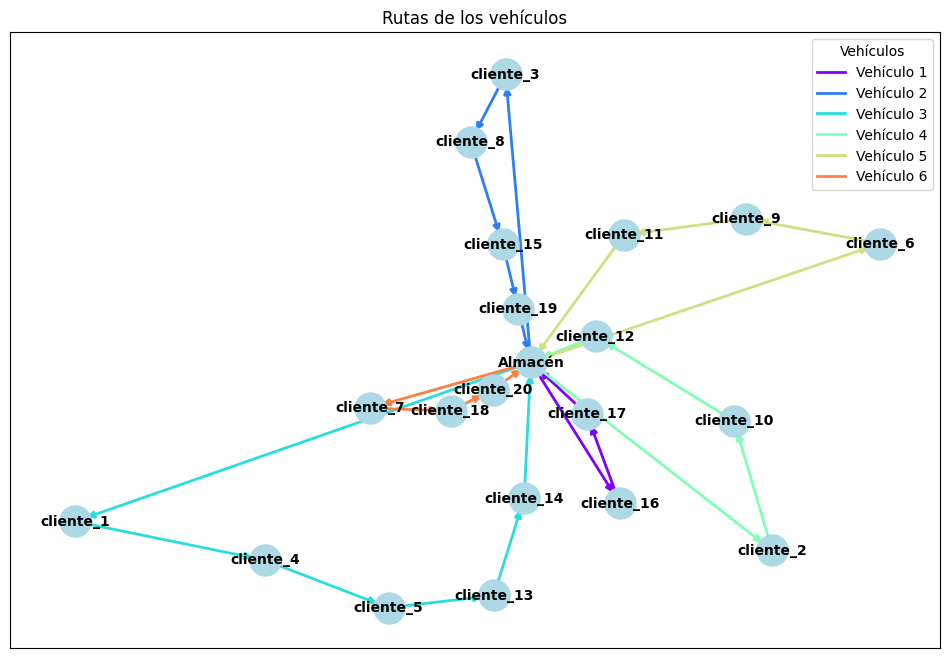

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Crear grafo para la representación gráfica
G = nx.DiGraph()

# Añadir nodos y aristas basados en las rutas
for v, datos in rutas_por_vehiculo.items():
    if datos["ruta"]:
        ruta = [nombre_almacen] + datos["ruta"] + [nombre_almacen]
        for i in range(len(ruta) - 1):
            G.add_edge(ruta[i], ruta[i + 1], weight=dicc_distancia[ruta[i]][ruta[i + 1]])

# Generar colores únicos para cada vehículo
edge_colors = plt.cm.rainbow([i / len(rutas_por_vehiculo) for i in range(len(rutas_por_vehiculo))])

# Posiciones de los nodos
pos = nx.spring_layout(G, seed=42)

# Dibujar nodos y etiquetas
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=500)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

# Dibujar aristas por vehículo con colores distintos
legend_elements = []  # Lista para construir la leyenda
for idx, (v, datos) in enumerate(rutas_por_vehiculo.items()):
    if datos["ruta"]:
        ruta = [nombre_almacen] + datos["ruta"] + [nombre_almacen]
        edges = [(ruta[i], ruta[i + 1]) for i in range(len(ruta) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=[edge_colors[idx]], width=2.0)
        legend_elements.append(Line2D([0], [0], color=edge_colors[idx], lw=2, label=f"Vehículo {v}"))

# Añadir título y leyenda
plt.title("Rutas de los vehículos")
plt.legend(handles=legend_elements, loc="best", title="Vehículos", fontsize=10)
plt.show()
